# Stochastic Gradient Descent on Linear Regression

![gym](https://images.unsplash.com/photo-1571902943202-507ec2618e8f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Z3ltfGVufDB8fDB8fA%3D%3D&auto=format&fit=crop&w=500&q=60)

### Table of Contents

* [Introduction](#Introduction)
* [Import Libraries](#Lib)
* [EDA and Cleaning the Data](#EDA)
* [Data Plots](#Plots)
* [Building the Model](#Model)
* [Graph Accuracy of Model](#Graph)
* [Scaling the Data](#Scaling)
* [Hyperparameter Tuning](#Hyper)
* [Final Model](#Final)
* [Conclusion](#Conclusion)


<a id='Introduction'></a>
## Introduction

The goal of this project is to determine how to best predict when the gym is likely to be crowded.  
By doing so an individual can maximize their workout by being less likely to be interupted due to over crowding.

First determine relevent features and then use the [SGDRegressor linear model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).  
This model is fitted by minimizing regularized empirical loss using stochastic gradient descent.  

Afterwards improve model by scaling data and then optimizing parameters.

The dataset [Crowdedness at the Campus Gym](https://www.kaggle.com/datasets/nsrose7224/crowdedness-at-the-campus-gym) contains the following features:

* number_people (number of people at gym at each observation)
* date (specific date and time information)
* timestamp (number of seconds since the start of the day (00:00))
* dayofweek (0 is equal to Monday, 6 to Sunday)
* is_weekend (observation during weekend: 1 for yes, 0 for no)
* is_holiday (observation during holiday: 1 for yes, 0 for no)
* temperature (temp when observation was taken in Fahrenheit)
* isstartof_semester (observation during first 2 weeks of semester: 1 for yes, 0 for no)
* is_during_semester (observation during active semester: 1 for yes, 0 for no)
* month (month of the year: 1 is equal to January, 12 is equal to December)
* hour (hour of the day: 0 is equal to 12:00am, 23 is equal to 11:00pm)

<a id='Lib'></a>
## Import Libraries

Import libraries needed for project and [create function that adds numerical values to the top of bars in seaborn barplots](https://www.statology.org/seaborn-barplot-show-values/)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set_style(style="whitegrid")

# Function used to add labels containing values to top of bars in seaborn barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        

In [2]:
# read csv file into pandas dataframe
gym=pd.read_csv('crowdness_gym_data.csv')
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [3]:
gym.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


<a id='EDA'></a>
## EDA and Cleaning the Data

Next remove *date and timestamp* columns; these two columns are redundant due to *hour, day_of_week, and month* already existing in the dataset.  

In [4]:
# drop columns and create new dataframe
gym_modif=gym.drop(columns=['timestamp','date'])

In [5]:
gym_modif.describe()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


Initial statistics of the data look fairly reasonable.

Next will look at data distributions of different features.

<a id='Plots'></a>
## Data Plots

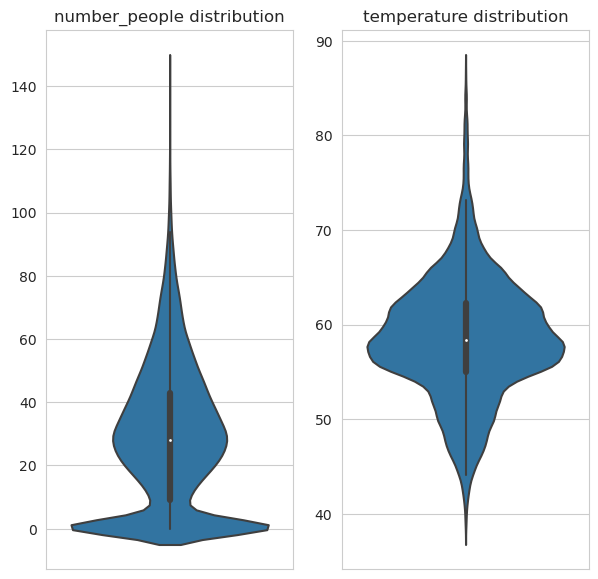

In [6]:
dist_cols=['number_people', 'temperature']

plt.figure(figsize=(7,7))

# Loop to plot violin plots of number_people and temperatures
for i, col in enumerate(dist_cols):
    plt.subplot(1,2,i+1)
    sns.violinplot(data=gym_modif, y=col)
    plt.title(f'{col} distribution')
    plt.ylabel('')
plt.show()        

* number_people (mean of 29, min of 0, max of 145)
* temperature (mean of 59F, min of 38F, max of 87F)

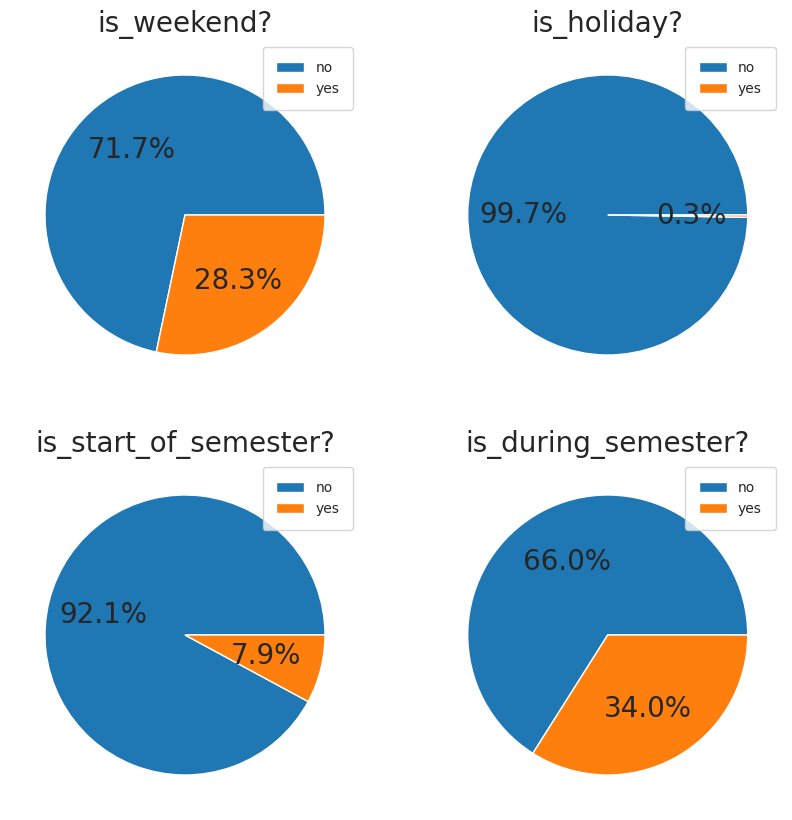

In [7]:
# pie charts of binary features percentage of the total dataset
yes_no=['is_weekend', 'is_holiday', 'is_start_of_semester', 'is_during_semester']

plt.figure(figsize=(10,10))

for i, cat in enumerate(yes_no):
    plt.subplot(2,2,i+1)
    gym_modif[cat].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', labeldistance=None,textprops={'fontsize': 20})
    plt.title(f'{cat}?', fontsize=20)                                                    
    plt.ylabel('')  
    plt.legend(['no','yes'],fontsize=10, borderpad=1)
plt.show() 

Nothing stands out as odd.  There are very few datapoints taken during the holidays.  
Likely the gym might be closed on many of those days or the fact that only a small percentage of days out of the year are a holiday.

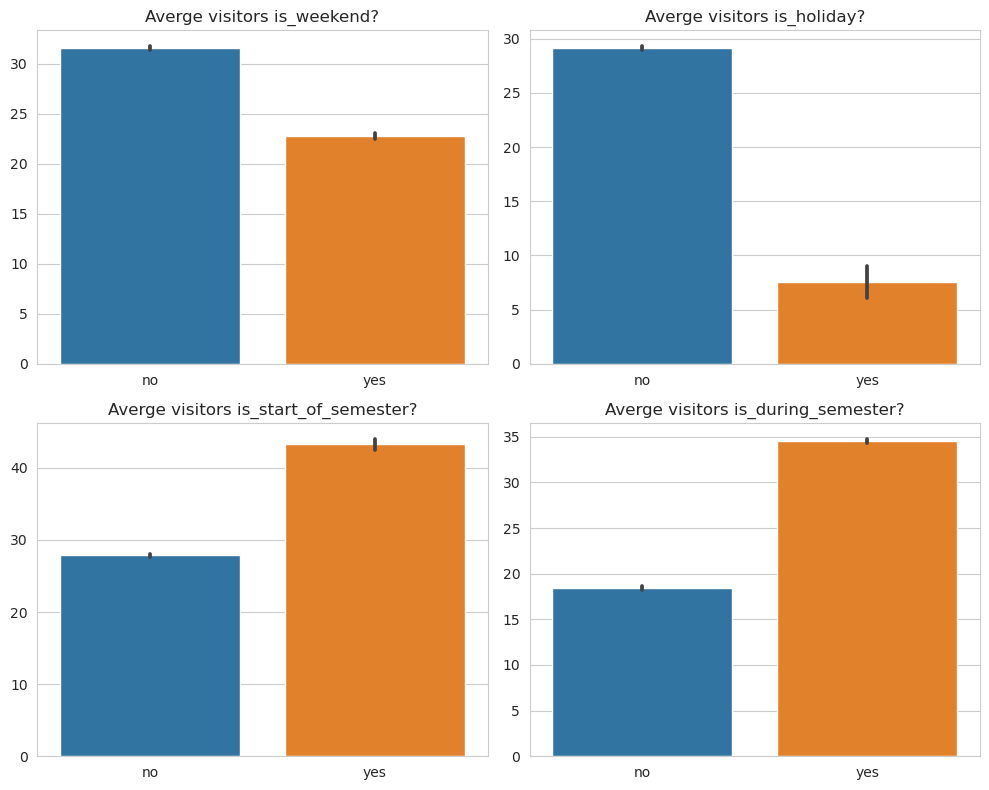

In [8]:
# bar charts of binary features showing average visitors
plt.figure(figsize=(10,8))
for i, col in enumerate(yes_no):
    plt.subplot(2,2,i+1)
    sns.barplot(data=gym_modif, y='number_people', x=col, orient='v')
    plt.title(f'Averge visitors {col}?')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks=[0,1],labels=['no','yes'])
plt.tight_layout()
plt.show() 

* Average visitors drop from about 32 during the week to about 23 during the weekend
* Average visitors drop from about 28 during normal times to only about 8 during holidays
* Average visitors increase to over 40 at the start of a semester
* Average visitors during semester are at about 34

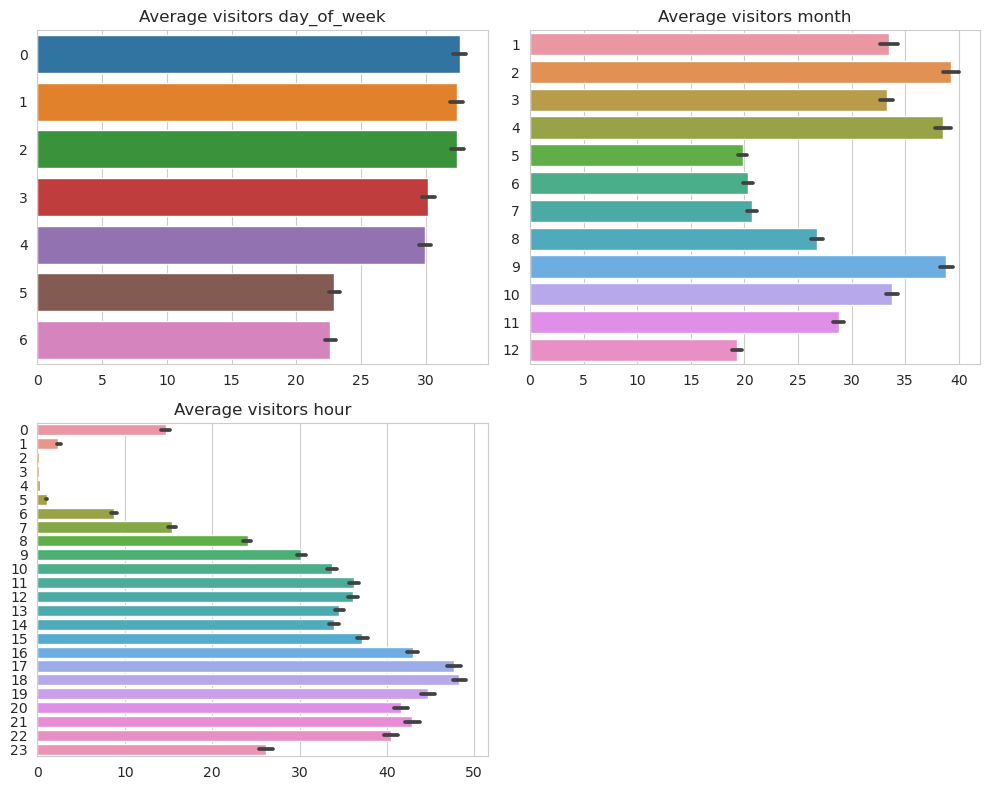

In [9]:
hist=['day_of_week','month', 'hour']

plt.figure(figsize=(10,8))

# create barplots of time related features
for i, col in enumerate(hist):
    plt.subplot(2,2,i+1)
    sns.barplot(data=gym_modif, x='number_people', y=col, orient='h')
    plt.title(f'Average visitors {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show() 

* Average visitors during the week tend to decrease as the week goes on
* Average visitors tend to decreased during the summer and winter breaks
* Average visitors in the early morning tend to be very low and the peak of activity is from 5:00pm to 10:00pm

Next will create *Correlation Chart* to determine what features have the highest correlation to gym attendance.

Text(0.5, 1.0, "Pearson's Correlation Chart")

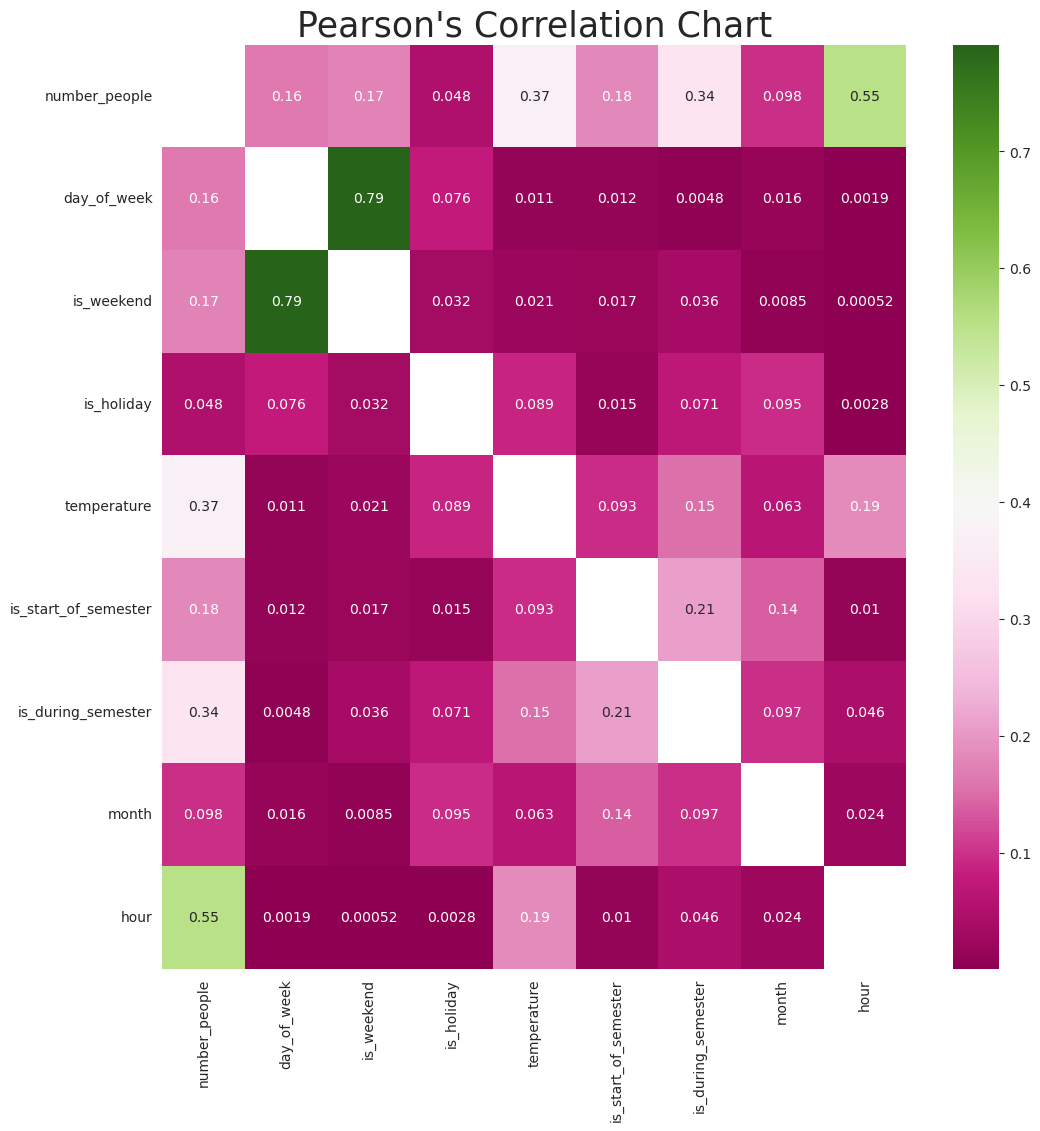

In [10]:
# create correlations
corr=abs(gym_modif.corr())

# plot correlations
plt.figure(figsize=(12,12))
sns.heatmap(corr[corr<1], cmap="PiYG", annot=True)
plt.title("Pearson's Correlation Chart", fontsize=25) 

Strongest to weekest correlations with number_people

* hour - 0.55
* temperature - 0.37
* is_during_semester - 0.34
* is_start_of_semester - 0.18
* is_weekend - 0.17
* day_of_week - 0.16
* month - 0.098
* is_holiday - 0.048

<a id='Model'></a>
## Building the Model

We will model the data using a SGDRegressor.

[Linear model fitted by minimizing a regularized empirical loss with SGD. SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)

For the start the default parameters will be used with only random_state chosen for repeatable results.

In [11]:
# break dataset into predictor and outcome datasets

X=gym_modif.drop(columns='number_people')
y=gym_modif['number_people']

# Split data into training and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=47)

In [12]:
# create SGDRegressor object

sgdr=SGDRegressor(random_state=47)
# train model on the data

sgdr.fit(X_train, y_train)
# make predictions with the model
y_pred=sgdr.predict(X_test)

# print out metrics
mse=mean_squared_error(y_test, y_pred)
score = sgdr.score(X_test, y_test)
iterations = sgdr.n_iter_

print(f'r2 is {score:.3f} with mse of {mse:.3f} with {iterations} iterations')

r2 is 0.481 with mse of 266.804 with 972 iterations


<a id='Graph'></a>
## Graph Accuracy of the Model

To visualize the success of the model a scatter plot of predicted values vs actual values will be generated.

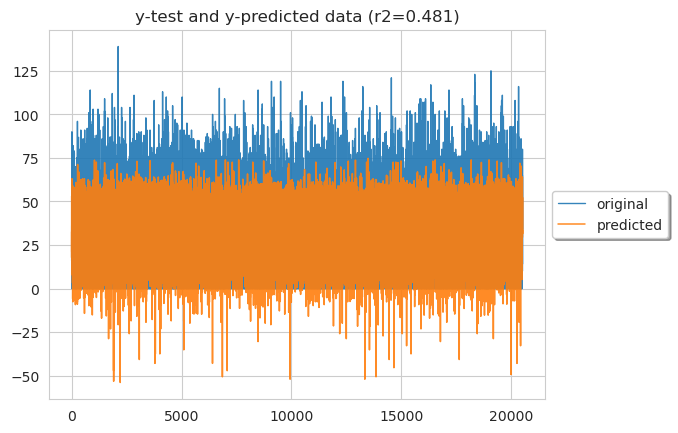

In [13]:
# Create function to create scatter plot of predicted values vs 
def graph_test_accuracy(y_test, y_pred, score):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, linewidth=1, label="original", alpha=0.9)
    plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted", alpha=0.9)
    plt.title(f"y-test and y-predicted data (r2={score:.3f})")
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show() 

# graph results    
graph_test_accuracy(y_test, y_pred, score) 

<a id='Scaling'></a>
## Scaling the Data

Next to improve accuracy of the model the features in the predictor features in the dataset by normalizing the data to a [standard scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

*StandardScaler* scales data based on the standard deviation of the value.  If the value is close to zero it means that the data has a very small standard deviation.  
Higher numbers mean more variance from the mean.

In [14]:
# scaled predictor dataset to standard scale
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

# split scaled data to train and test datasets
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.33, random_state=47)

In [15]:
# create new model object
sgdr=SGDRegressor(random_state=47)

# fit data to model
sgdr.fit(X_train, y_train)

# make predictions using model
y_pred=sgdr.predict(X_test)

# generate metrics
mse=mean_squared_error(y_test, y_pred)
score = sgdr.score(X_test, y_test)
iterations = sgdr.n_iter_

print(f'r2 is {score:.3f} with mse of {mse:.3f} with {iterations} iterations')

r2 is 0.503 with mse of 255.473 with 12 iterations


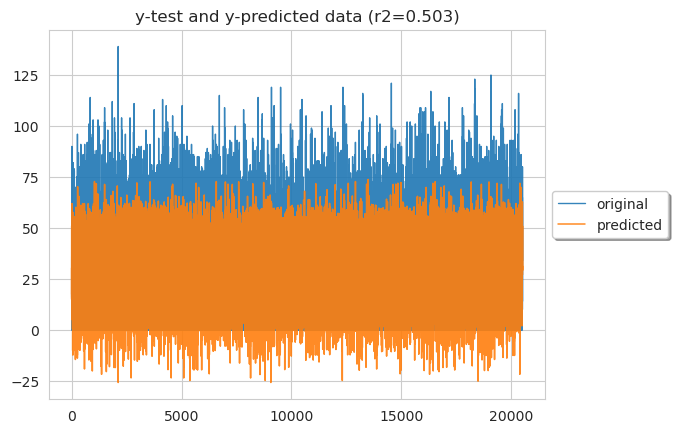

In [16]:
graph_test_accuracy(y_test, y_pred, score)  

<a id='Hyper'></a>
## Hyperparameter Tuning

Next will attempt to improve model by changed parameters.  Will concentrate on learning_rate, alpha and eta0 parameters.

* learning_rate - Learning Rate Schedule
* alpha - Constant that multiplies the regularization term
* eta0 -  Initial learning rate

Text(0.5, 1.0, 'Accuracy with different learning rate schedules')

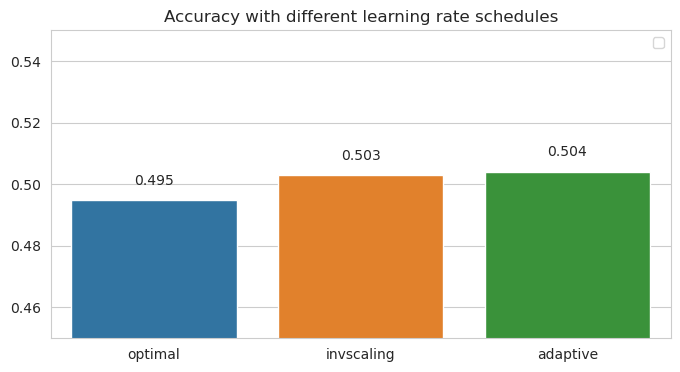

In [17]:
# create list of different learning_rate schedule parameter values and dictionary to store accuracy results
accuracy={}
learning_rate=['optimal', 'invscaling', 'adaptive']

# created loop trying different learning_rate parameters
for rate in learning_rate:
    sgdr=SGDRegressor(random_state=47, learning_rate=rate)
    sgdr.fit(X_train, y_train)
    y_pred=sgdr.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    score = sgdr.score(X_test, y_test)
    accuracy[rate]=score

# create bar graph using accuracy dictionary created in prior loop    
plt.figure(figsize=(8,4))    
p=sns.barplot(x=list(accuracy.keys()), y=list(accuracy.values()))
show_values(p)
plt.legend('')
plt.ylim(0.45,0.55)
plt.title('Accuracy with different learning rate schedules')

Results show that *adaptive* setting is best schedule for *learning_rate* parameter.

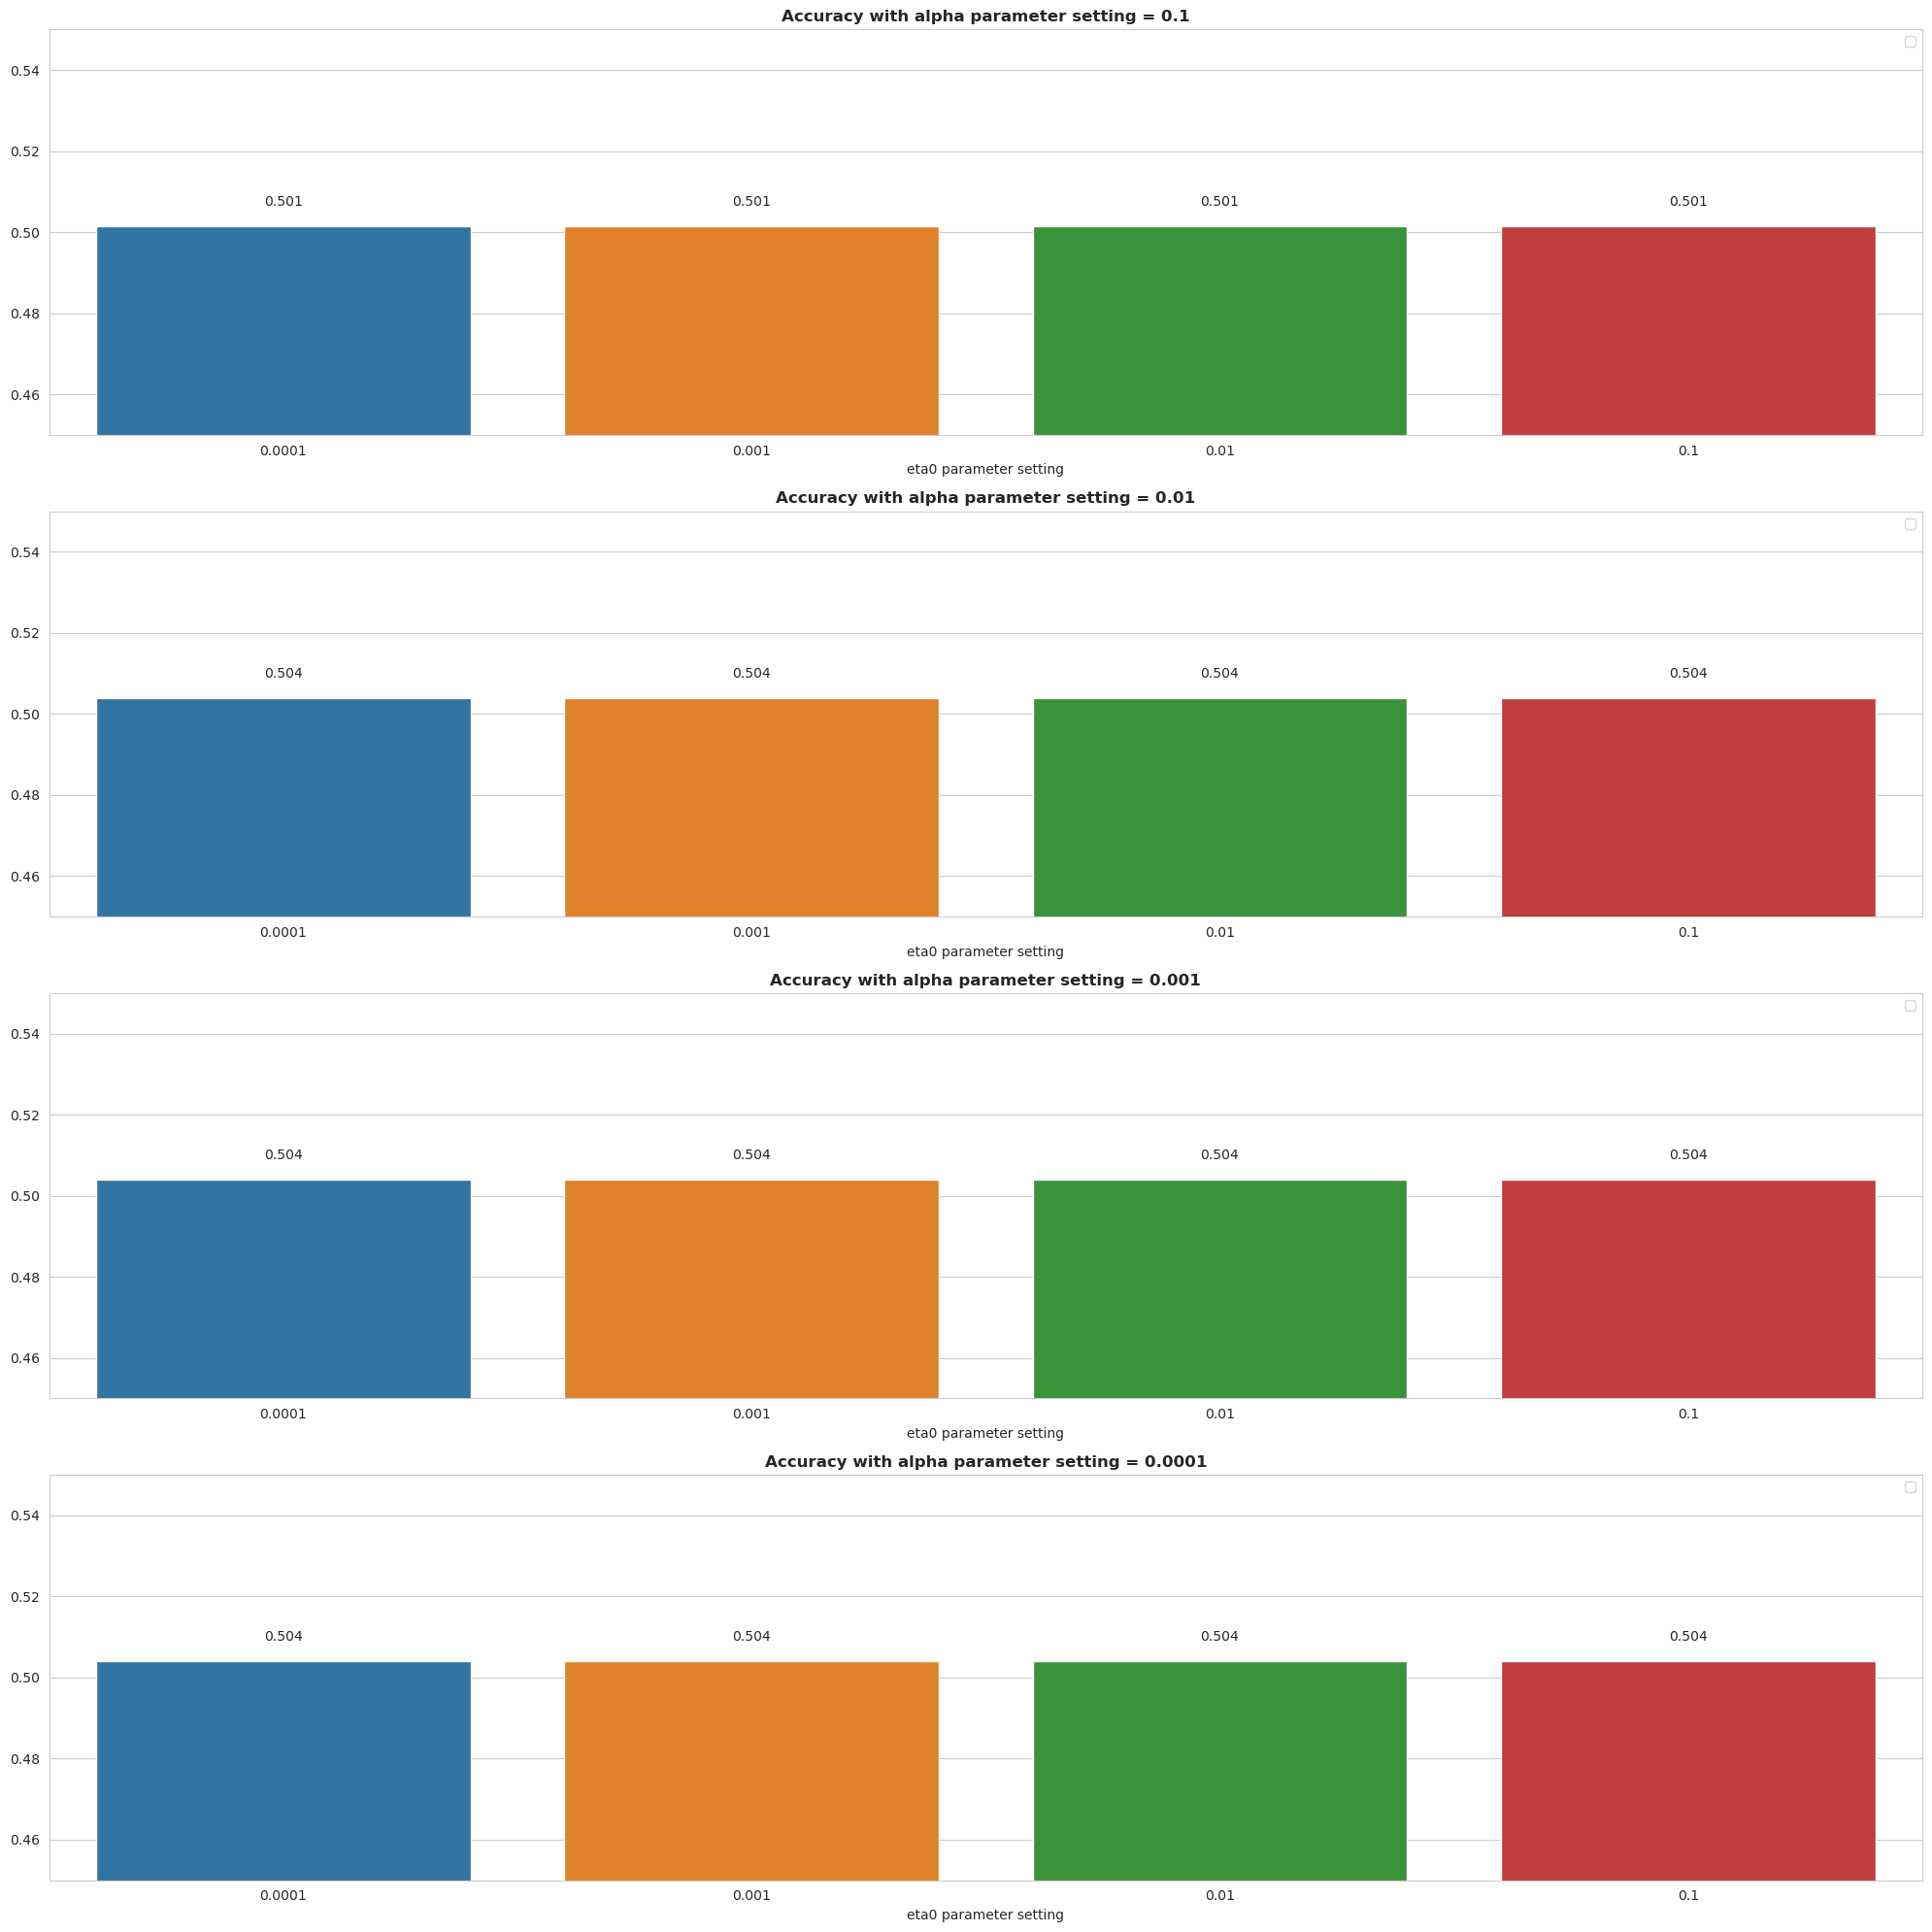

In [18]:
# crated list of different parameter values for alpha and eta0.  
alpha_eta=[0.1, .01, 0.001, 0.0001]

plt.figure(figsize=(20,20))

# create nested loop for different values of alpha and eta0 parameters
for a, par in enumerate(alpha_eta):
    accuracy={}
    for e in alpha_eta:
        sgdr=SGDRegressor(max_iter=10000, random_state=47, learning_rate='adaptive', alpha=par, eta0=e)
        sgdr.fit(X_train, y_train)
        y_pred=sgdr.predict(X_test)
        mse=mean_squared_error(y_test, y_pred)
        score = sgdr.score(X_test, y_test)
        accuracy[e]=score

# Plot accuracy dictionary generated above         
    plt.subplot(4,1,a+1)
    p=sns.barplot(x=list(accuracy.keys()), y=list(accuracy.values()))
    show_values(p)
    plt.legend('')
    plt.ylim(0.45,0.55)
    plt.title(f'Accuracy with alpha parameter setting = {par}', weight='bold')
    plt.xlabel('eta0 parameter setting')
    plt.tight_layout()
                

There was no substantial differences in the accuracy scores.  Results range from 0.501 to 0.504.

There does not seem to be any significant improvement in the accuracy scores.  However, accuracy is not the only important metric in a model.  Efficent models are also important.

If a model is slow, the model will take more resources whether it be computing power or just the time itself that could be used for other work.  This is not an issue for relatively small datsets such as this one, but could be an issue in larger datasets.

Will run alpha/eta0 parameter check, but capturing total iterations instead of accuracy.

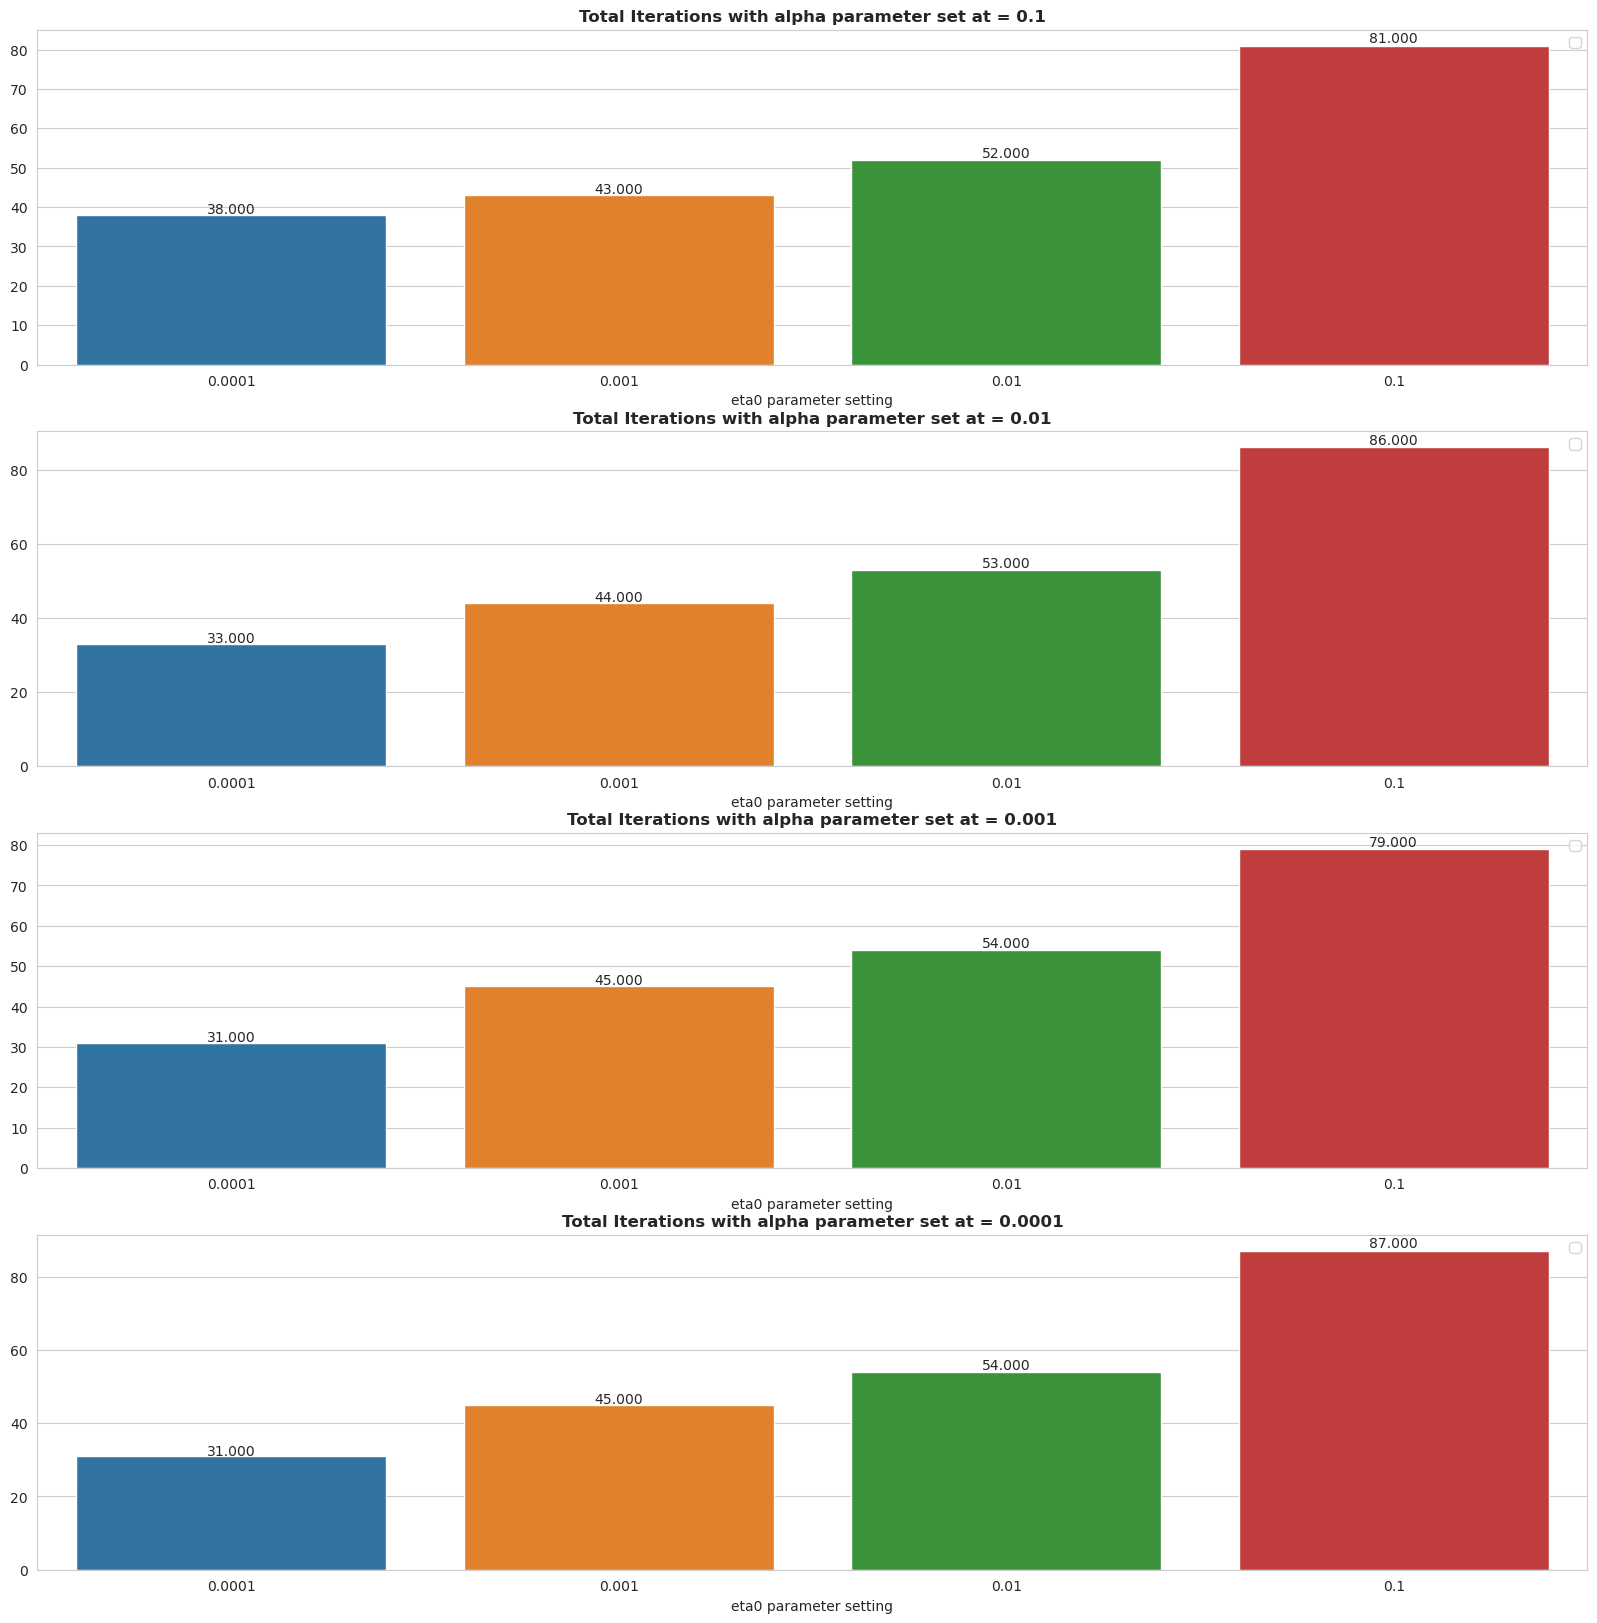

In [19]:
alpha_eta=[0.1, .01, 0.001, 0.0001]

plt.figure(figsize=(20,20))

# rerun and capture total iterations
for a, par in enumerate(alpha_eta):    
    iterations={}
    for e in alpha_eta:
        sgdr=SGDRegressor(random_state=47, learning_rate='adaptive', alpha=par, eta0=e)
        sgdr.fit(X_train, y_train)
        y_pred=sgdr.predict(X_test)
        iterations[e]=sgdr.n_iter_
        
    plt.subplot(4,1,a+1)
    p=sns.barplot(x=list(iterations.keys()), y=list(iterations.values()))
    show_values(p)
    plt.legend('')
    plt.title(f'Total Iterations with alpha parameter set at = {par}', weight='bold')
    plt.xlabel('eta0 parameter setting')

Going off of the total iterations as accuracy is more or less equal.

The optimum parameters:

* alpha = 0.001
* eta0 = 0.0001

<a id='Final'></a>
## Final Model

Create final model with improved parameters and plot the results.

In [20]:
# create sgdr object
sgdr=SGDRegressor(max_iter=10000, random_state=47, learning_rate='adaptive', alpha=0.001, eta0=0.0001)

# fit data to model
sgdr.fit(X_train, y_train)

# make predictions with model
y_pred=sgdr.predict(X_test)

# metrics of model
mse=mean_squared_error(y_test, y_pred)
score = sgdr.score(X_test, y_test)
iterations = sgdr.n_iter_
b=sgdr.intercept_

print(f'r2 is {score:.3f} with mse of {mse:.3f} with {iterations} iterations')
coef_df=pd.DataFrame(sgdr.coef_, index=X.columns, columns=['coef'])
coef_df


r2 is 0.504 with mse of 254.901 with 31 iterations


,coef
day_of_week,-1.779990
is_weekend,-2.292344
is_holiday,-0.627858
temperature,5.529237
is_start_of_semester,1.825008
is_during_semester,6.018933
month,-2.606443
hour,11.157636


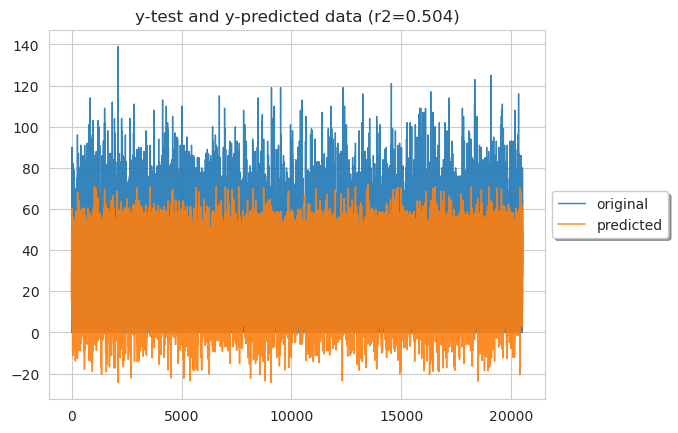

In [21]:
graph_test_accuracy(y_test, y_pred, score)

Predicted values tend skew lower than original values.

Text(0.5, 1.0, 'linear plots based on features used in model')

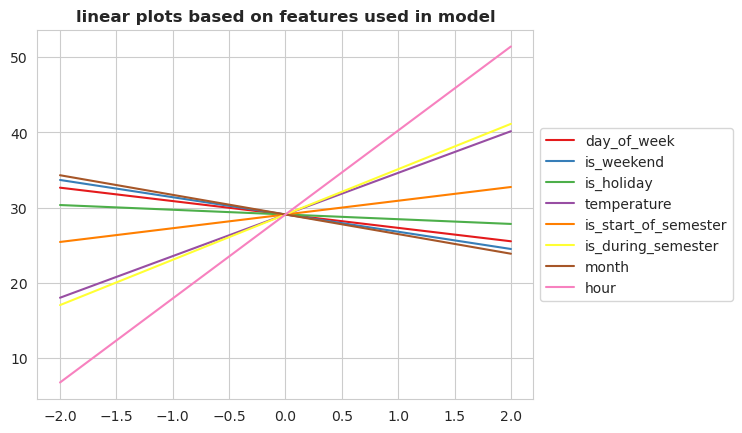

In [22]:
# graph features by model coefficients and intercept
colors=sns.color_palette('Set1')
coef=sgdr.coef_

x=np.linspace(-2,2,1000)

for i, col in enumerate(X.columns):
    y=coef[i]*x+b
    plt.plot(x,y,label=col, color=colors[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('linear plots based on features used in model', weight='bold')             

*Hour, is_during_semester, and temperature* tend to be strongly positively correlated to increased attendance.

*Month, weekend, and day_of_week* tend to have a moderate negative correlation to attendance.

<a id='Conclusion'></a>
## Conclusion

**Overall Results:**

* Non-Scaled data - r2 is 0.481 with mse of 266.804 with 972 iterations
* Scaled data - r2 is 0.503 with mse of 255.473 with 12 iterations
* Optimized parameters with scaled data - r2 is 0.504 with mse of 254.901 with 31 iterations

Scaling the data led to the greatest imporovement in accuracy and total number of iterations.  
There was little improvement with optimizing the parameters.

The strongest coefficients in the model were *hour, is_during_semester and temperature.*

Overall the gym is busiest late in the day and visits slowly go down as the week goes on with a dip in attendence during the weekends.